In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/playground-series-s5e11/sample_submission.csv
/kaggle/input/playground-series-s5e11/train.csv
/kaggle/input/playground-series-s5e11/test.csv


## Goal : Predict the probability that a borrower will pay back their loan 

## Importing Libraries 

In [2]:
import pandas as pd 
import numpy as sns 

import matplotlib.pyplot as plt 
import seaborn as sns
%matplotlib inline 

import warnings 
warnings.filterwarnings('ignore')

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score,classification_report, confusion_matrix,precision_score,recall_score,f1_score

## Data Loading

In [3]:
train = pd.read_csv('/kaggle/input/playground-series-s5e11/train.csv')

In [4]:
test = pd.read_csv('/kaggle/input/playground-series-s5e11/test.csv')

In [5]:
submission =pd.read_csv('/kaggle/input/playground-series-s5e11/sample_submission.csv') 

In [6]:
output = pd.DataFrame()
output['id']=test['id']
output.head()

,id
0,593994
1,593995
2,593996
3,593997
4,593998


## Exploratory Data Analysis 

In [7]:
def eda(df):
    print("Performing EDA")
    print("1.Shape of the dataset",df.shape)
    print("<<<<<<<<<<<<<<<<<<<<<<<<<<<>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>")
    print("2.Exploratory Data Analysis:")
    print(df.head())
    print("><<><><><><><><><><><><><><><><><><><><<<>>><<<>>><<<>>><<<>>><<<>>><<<>>>")
    print("3.Information about Data")
    data_info=pd.DataFrame(df.dtypes,columns=['datatype'])
    data_info['Duplicate_Values']=df.duplicated().sum()
    data_info['Missing_Values']=df.isna().sum()
    data_info['Unique_Values']=df.nunique().sum()
    data_info['Missing_Values_Percentage']=df.isna().sum()/len(df)
    df_describe = df.describe(include='all').T
    #print(df_describe)
    data_info["Count"]= df_describe['count'].values
    data_info['Mean'] = df_describe['mean'].values
    data_info['Std'] = df_describe['std'].values
    data_info['Min'] = df_describe['min'].values
    data_info['Max'] = df_describe['max'].values
    data_info = data_info[['datatype','Count','Mean','Std','Min','Max','Duplicate_Values','Missing_Values','Unique_Values','Missing_Values_Percentage']]
    print("Over all Summary:",data_info)
    print('><<><><><><><><><><><><><><><><><><><><<<>>><<<>>><<<>>><<<>>><<<>>><<<>>>')
    print('Correlation Matrix on Numerical Features')
    num_cols = df.select_dtypes(exclude = 'object').columns.tolist()
    cat_cols = df.select_dtypes(include = 'object').columns.tolist()
    Correlation_Matrix = df[num_cols].corr()
    print('><<><><><><><><><><><><><><><><><><><><<<>>><<<>>><<<>>><<<>>><<<>>><<<>>>')
    print('Visualizing The Correlation Matrix')
    plt.figure(figsize=(14,9))
    sns.heatmap(Correlation_Matrix,annot=True,cmap='viridis',linewidth=0.5)
    plt.show()
    print('><<><><><><><><><><><><><><><><><><><><<<>>><<<>>><<<>>><<<>>><<<>>><<<>>>')
    print("Distribution of Numerical Features")
    for col in num_cols:
        plt.figure(figsize=(5,3))
        sns.histplot(df[col],kde=True)
        plt.xlabel(col)
        plt.ylabel('Frequency')
        plt.title("Distribution of {}".format(col))
        plt.show()
    print('><<><><><><><><><><><><><><><><><><><><<<>>><<<>>><<<>>><<<>>><<<>>><<<>>>')
    print("Distribution of Categorical features")
    for col in cat_cols:
        plt.figure(figsize=(5,4))
        sns.countplot(x=col,data=df)
        plt.xlabel(col)
        plt.ylabel('Distribution')
        plt.title("Distribution of {}".format(col))
        plt.show()
    print('><<><><><><><><><><><><><><><><><><><><<<>>><<<>>><<<>>><<<>>><<<>>><<<>>>')
    print("Checking Outliers In The Numerical Features")
    for col in num_cols:
        plt.figure(figsize=(5,4))
        sns.boxplot(df[col])
        plt.xlabel(col)
        plt.title("Outliers of {}".format(col))
        plt.show()
    print('><<><><><><><><><><><><><><><><><><><><<<>>><<<>>><<<>>><<<>>><<<>>><<<>>>')
    print('Target Column Frequency')
    (df['loan_paid_back'].value_counts()/len(df)).plot(kind='bar') 

Performing EDA
1.Shape of the dataset (593994, 13)
<<<<<<<<<<<<<<<<<<<<<<<<<<<>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
2.Exploratory Data Analysis:
   id  annual_income  debt_to_income_ratio  credit_score  loan_amount  \
0   0       29367.99                 0.084           736      2528.42   
1   1       22108.02                 0.166           636      4593.10   
2   2       49566.20                 0.097           694     17005.15   
3   3       46858.25                 0.065           533      4682.48   
4   4       25496.70                 0.053           665     12184.43   

   interest_rate  gender marital_status education_level employment_status  \
0          13.67  Female         Single     High School     Self-employed   
1          12.92    Male        Married        Master's          Employed   
2           9.76    Male         Single     High School          Employed   
3          16.10  Female         Single     High School          Employed   
4          10.21    M

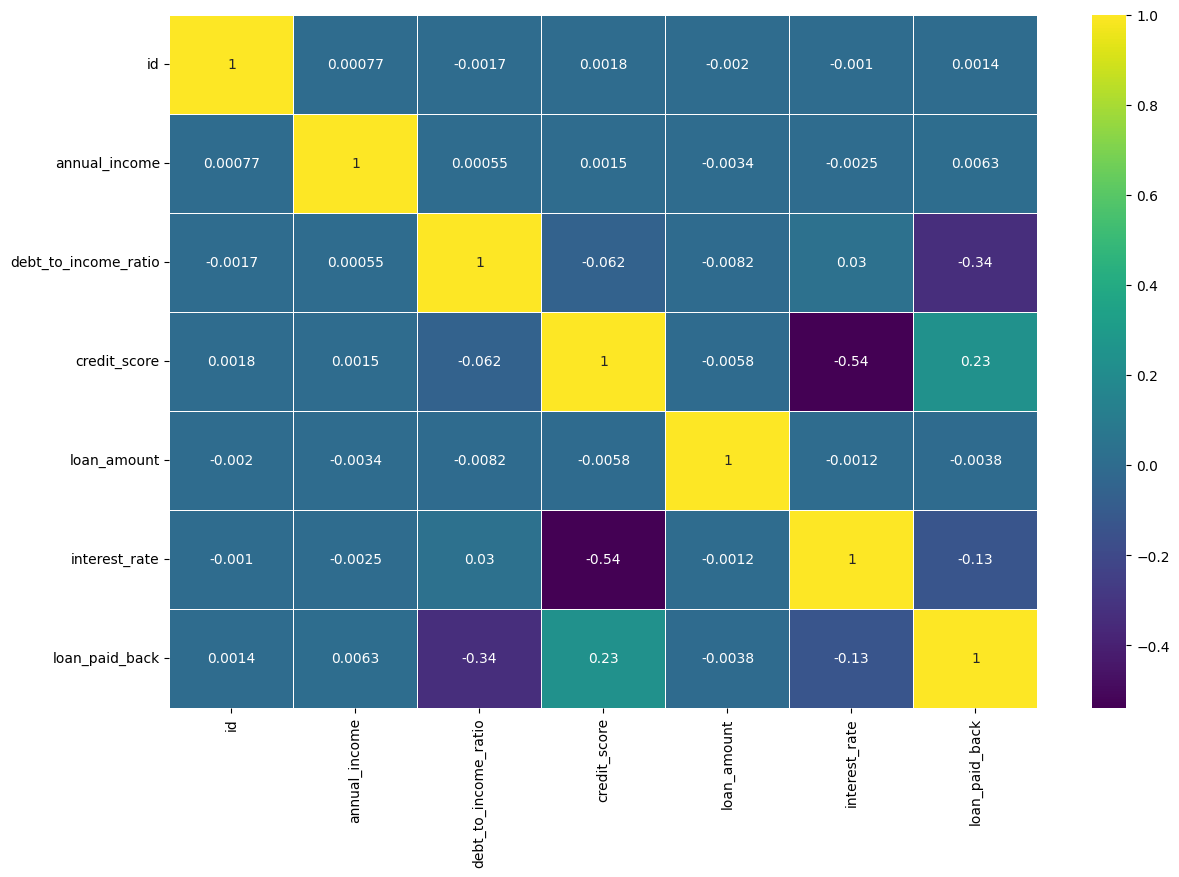

><<><><><><><><><><><><><><><><><><><><<<>>><<<>>><<<>>><<<>>><<<>>><<<>>>
Distribution of Numerical Features


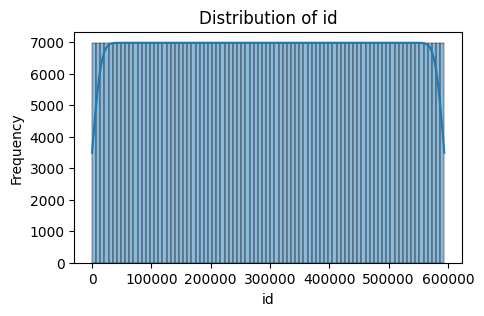

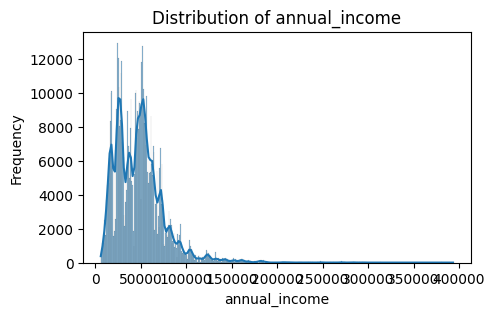

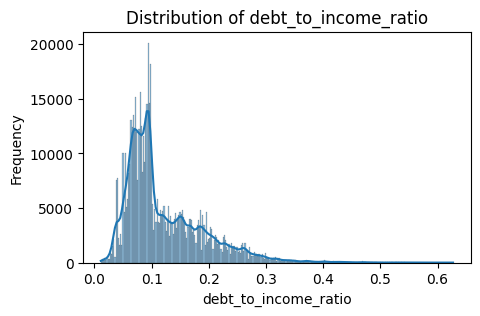

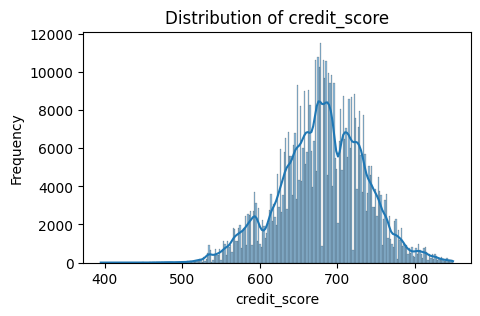

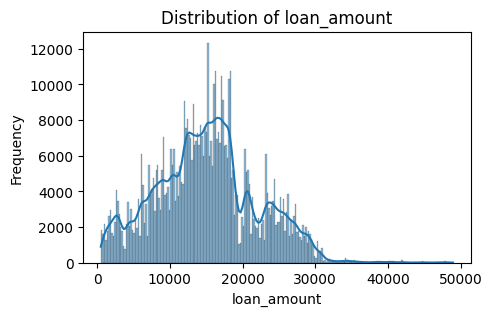

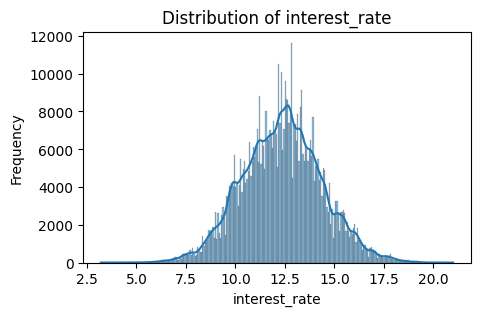

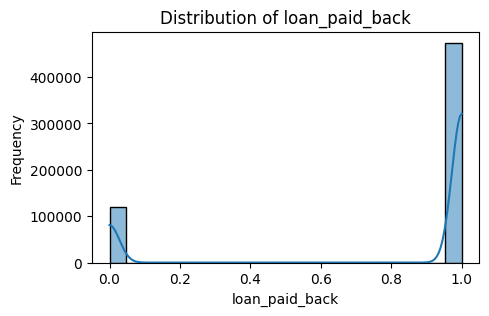

><<><><><><><><><><><><><><><><><><><><<<>>><<<>>><<<>>><<<>>><<<>>><<<>>>
Distribution of Categorical features


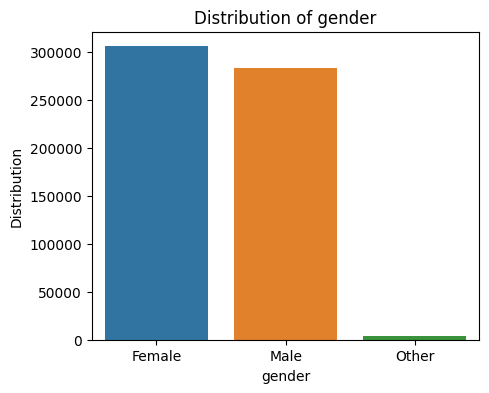

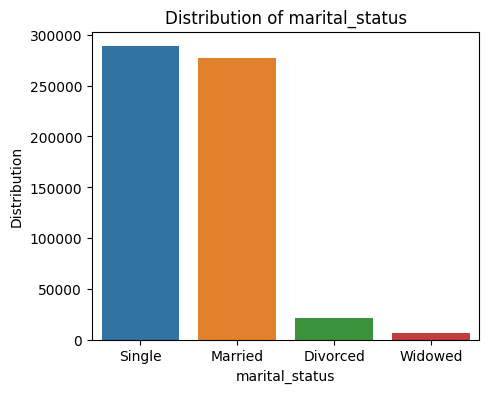

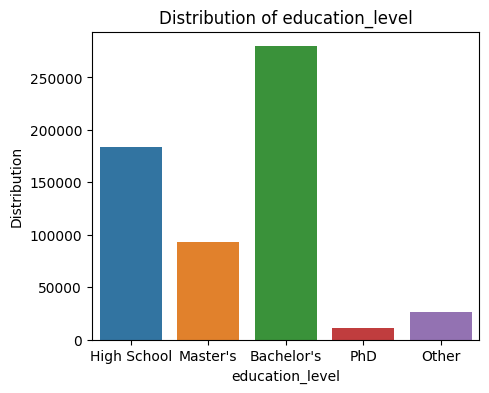

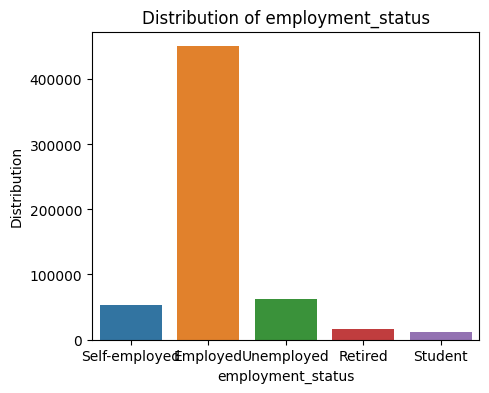

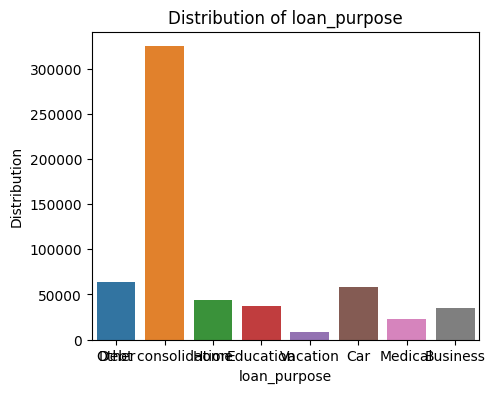

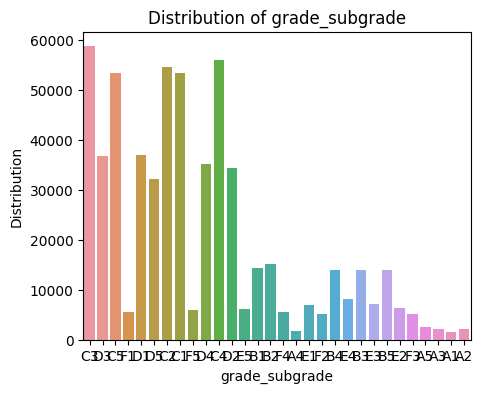

><<><><><><><><><><><><><><><><><><><><<<>>><<<>>><<<>>><<<>>><<<>>><<<>>>
Checking Outliers In The Numerical Features


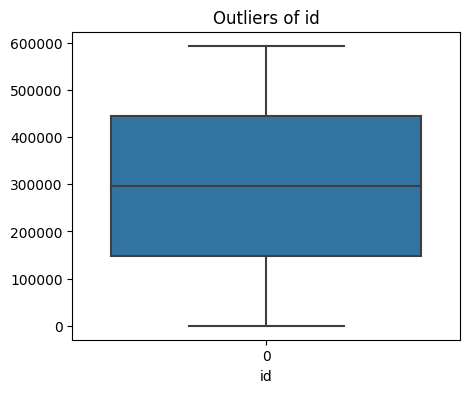

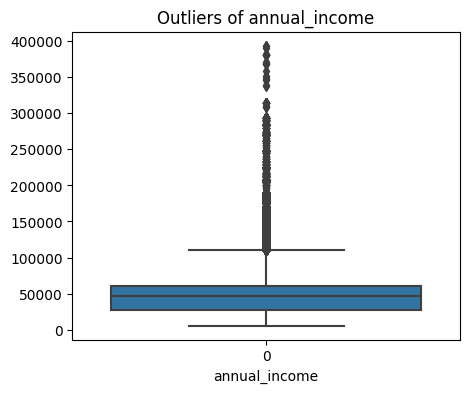

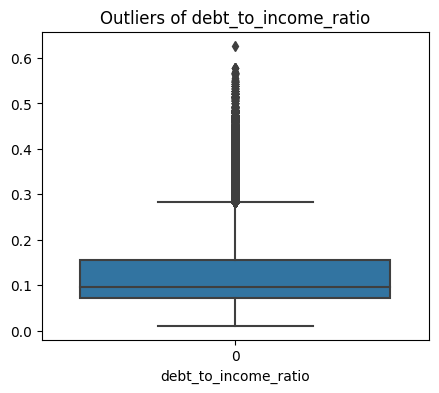

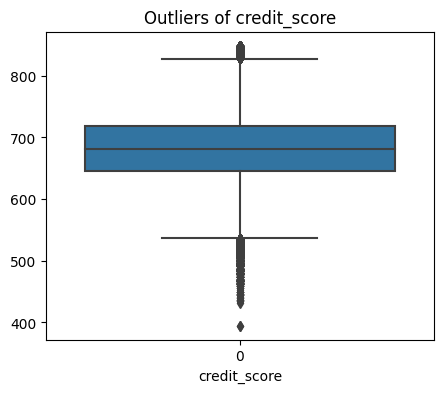

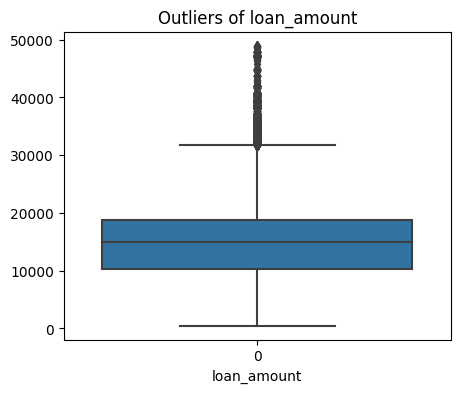

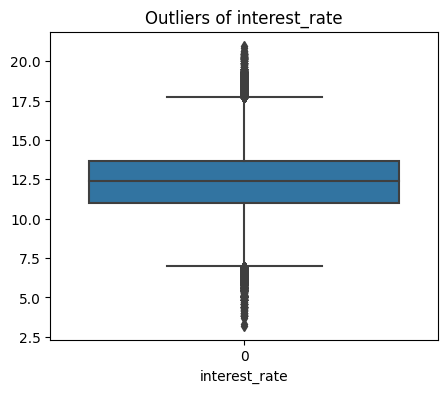

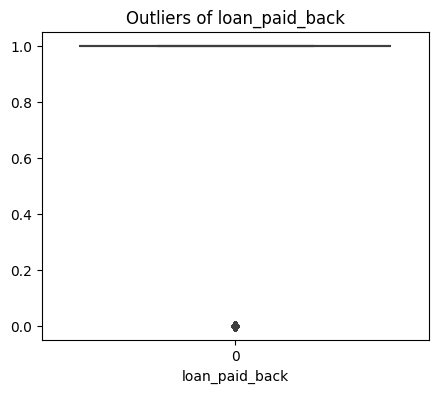

><<><><><><><><><><><><><><><><><><><><<<>>><<<>>><<<>>><<<>>><<<>>><<<>>>
Target Column Frequency


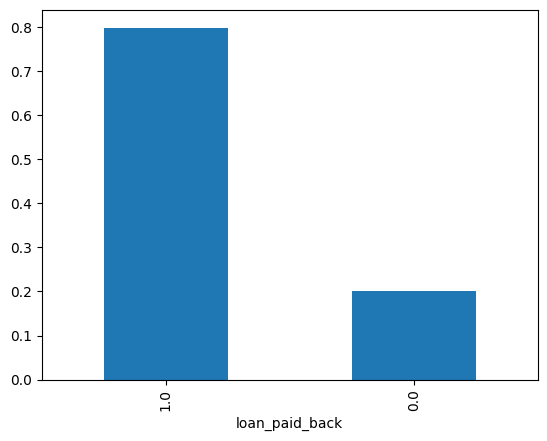

In [8]:
eda(train)

## Observations 

 ## Dataset Summary 📊

#### 1.There are 13 features in this dataset - 7 numerical features & 6-categorical features

#### 2.Target features is (load_paid_back)

#### 3.There is 'id' columns which is not useful analysis.

#### 4.No missing values & No duplicated records present in the dataset.

#### 5.Total 11 Input features & 1 output feature except 'id' column.

#### 6.In boxplot we observe few dot point in top and bottom side, They indicate outliers in columns. We need to treatthem.

#### 7.The data set is imbalanced. This is binary classification problem, 1.0 has majority classes, 0.0 has minority class. We need to balance the dataset.


## Distribution of data set 📈

#### 1.Debt to income ratio is right skewed, very less. The debt-to-income ratio (DTI) is a financial metric that compares a person's total monthly debt payments to their gross monthly income. It is expressed as a percentage and is used by lendersto assess an individual's ability to manage monthly debt payments and repay borrowed money.

#### 2.Debt to income ration is right skewed means most people have low or moderate debt compared to their income, but a few have much higher debt levels.

#### 3.Annual_income column is also right skewed distribution. it means most people earn a lower to middle range of income. but there are a few people who earn very high incomes which creates a long tail on the right side.

## Dropping Irrelevant Features

In [9]:
train = train.drop(['id'],axis=1)
test = test.drop(['id'],axis=1)

In [10]:
train = train.drop(['grade_subgrade'],axis=1)
test = test.drop(['grade_subgrade'],axis=1)

## Outlier Treatment

In [11]:
def outlier_treat(x):
    q1 = x.quantile(0.25)
    q3 = x.quantile(0.75)
    iqr = q3-q1
    lower_whisker = q1-1.5*iqr
    upper_whisker = q3+1.5*iqr
    return(x.clip(upper = upper_whisker, lower = lower_whisker))

In [12]:
out_cols = ["annual_income","debt_to_income_ratio","credit_score","loan_amount","interest_rate"]


In [13]:
train[out_cols]=train[out_cols].apply(outlier_treat)

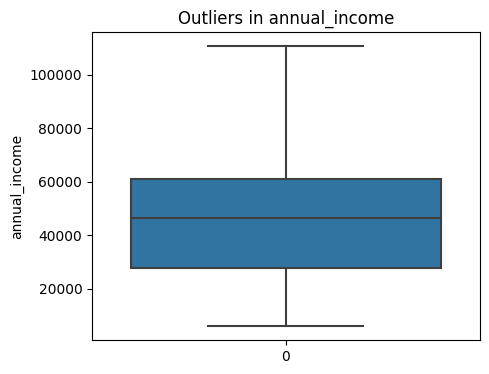

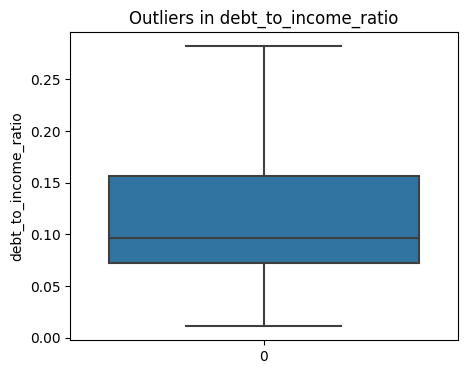

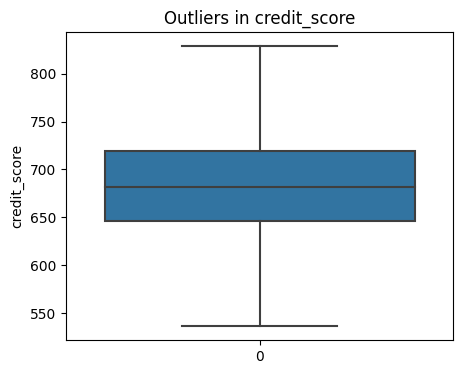

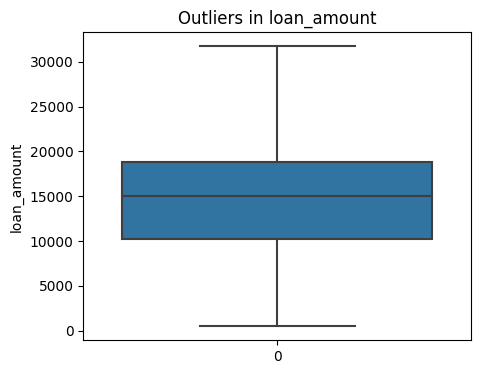

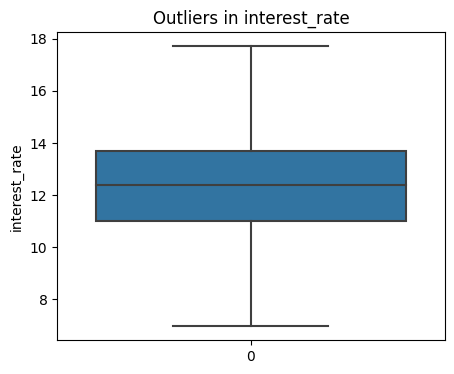

In [14]:
for col in out_cols:
    plt.figure(figsize=(5,4))
    sns.boxplot(train[col])
    plt.ylabel(col)
    plt.title(f"Outliers in {col}")
    plt.show()


In [15]:
test[out_cols]=test[out_cols].apply(outlier_treat)

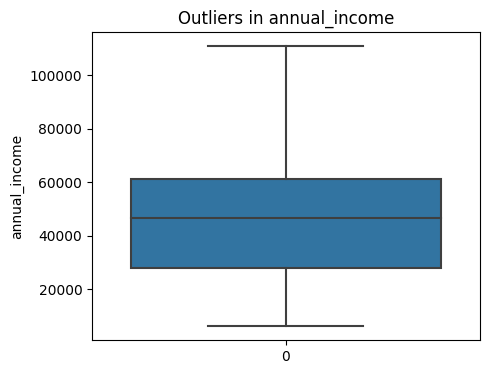

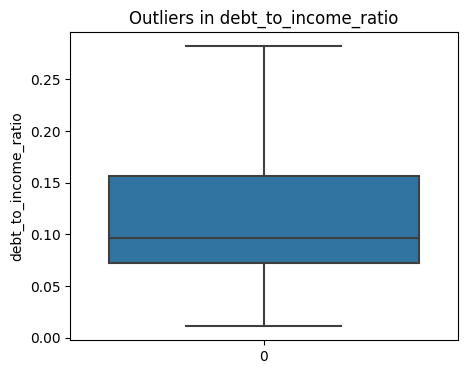

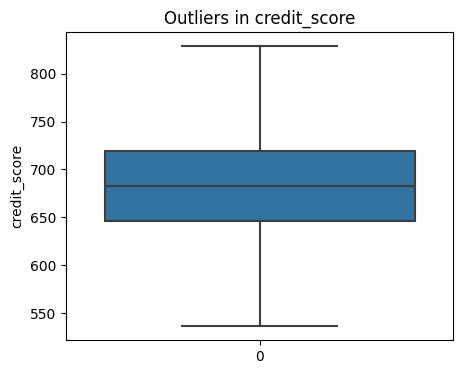

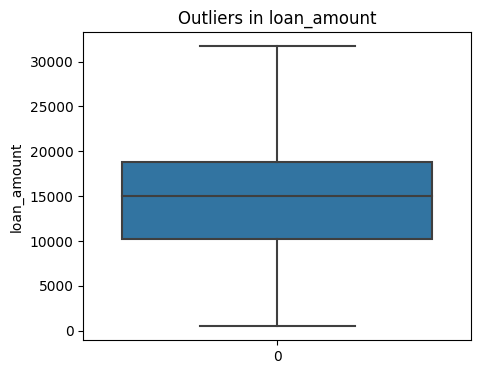

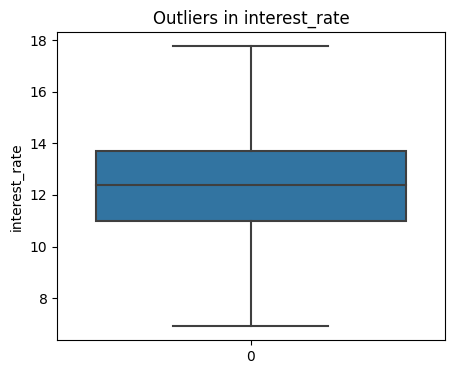

In [16]:
for col in out_cols:
    plt.figure(figsize=(5,4))
    sns.boxplot(test[col])
    plt.ylabel(col)
    plt.title(f"Outliers in {col}")
    plt.show()

## Pre Processing 

## Encoding For The Categorical Features 

In [17]:
onehot_cols = ['gender', 'marital_status', 'employment_status', 'loan_purpose']

In [18]:

train = pd.get_dummies(train, columns=onehot_cols, drop_first=True)
test  = pd.get_dummies(test,  columns=onehot_cols, drop_first=True)

train, test = train.align(test, join='left', axis=1, fill_value=0) 

train = train.apply(lambda x: x.astype(int) if x.dtype == 'bool' else x)
test  = test.apply(lambda x: x.astype(int) if x.dtype == 'bool' else x)


In [19]:
from sklearn.preprocessing import OrdinalEncoder

In [20]:
edu_order = [['High School', "Bachelor's", "Master's", 'PhD', 'Other']]
ord_enc = OrdinalEncoder(categories=edu_order) 

train['education_level'] = ord_enc.fit_transform(train[['education_level']])
test['education_level']  = ord_enc.transform(test[['education_level']])

In [21]:
train, test = train.align(test, join='left', axis=1, fill_value=0)

## Separating Features Into Training and Testing 

In [22]:
X = train.drop('loan_paid_back', axis=1)
y = train['loan_paid_back']

## Model Building 

## XGBoost 

 TRAINING METRICS 
Train Accuracy: 0.9046429129739415
Train Precision: 0.9053791459341086
Train Recall: 0.9833948561690443
Train F1 Score: 0.9427757836595846
 TRAINING CLASSIFICATION REPORT 
              precision    recall  f1-score   support

         0.0       0.90      0.59      0.71     83669
         1.0       0.91      0.98      0.94    332126

    accuracy                           0.90    415795
   macro avg       0.90      0.79      0.83    415795
weighted avg       0.90      0.90      0.90    415795

 TEST METRICS
Test Accuracy: 0.9036133760571047
Test Precision: 0.9051625932062966
Train Recall: 0.9833948561690443
Test F1 Score: 0.9421418562035141
 TEST CLASSIFICATION REPORT 
              precision    recall  f1-score   support

         0.0       0.89      0.59      0.71     35831
         1.0       0.91      0.98      0.94    142368

    accuracy                           0.90    178199
   macro avg       0.90      0.79      0.83    178199
weighted avg       0.90      0.

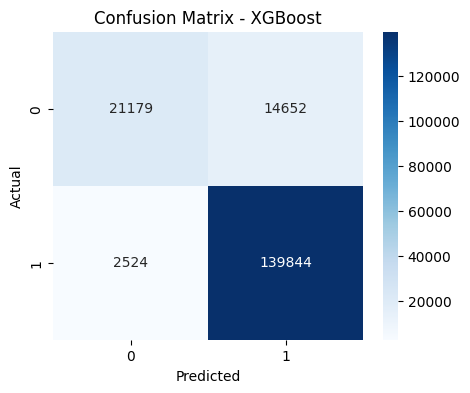

<Figure size 800x600 with 0 Axes>

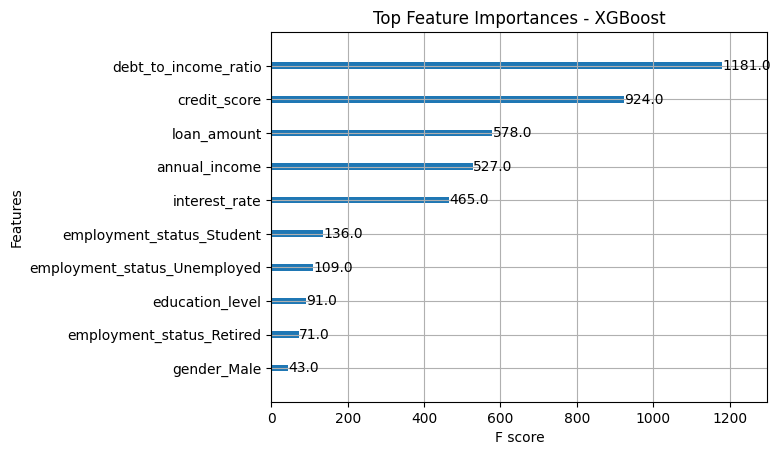

In [23]:
def new_model(X,y):
    X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3,random_state=45)
    
    model = XGBClassifier(      n_estimators=150,
                                learning_rate=0.1,
                                max_depth=5,
                                subsample=0.8,
                                eval_metric='logloss'
                                )

    # Train model
    model.fit(X_train, y_train)
    
    # TRAINING PREDICTIONS 
    train_pred = model.predict(X_train)
    train_pred_proba = model.predict_proba(X_train)[:, 1]

    

    print(" TRAINING METRICS ")
    print("Train Accuracy:", accuracy_score(y_train, train_pred))
    print("Train Precision:", precision_score(y_train, train_pred))
    print("Train Recall:", recall_score(y_train, train_pred))
    print("Train F1 Score:", f1_score(y_train, train_pred))

    

    print(" TRAINING CLASSIFICATION REPORT ")
    print(classification_report(y_train, train_pred))

   
    # TEST PREDICTIONS
   
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]

    print(" TEST METRICS")
    print("Test Accuracy:", accuracy_score(y_test, y_pred))
    print("Test Precision:", precision_score(y_test, y_pred))
    print("Train Recall:", recall_score(y_train, train_pred))
    print("Test F1 Score:", f1_score(y_test, y_pred))

    

    print(" TEST CLASSIFICATION REPORT ")
    print(classification_report(y_test, y_pred))

    

    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    print(" CONFUSION MATRIX ")
    print(cm)


    # Confusion matrix heatmap
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title("Confusion Matrix - XGBoost")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

    

    # Feature importance plot
    from xgboost import plot_importance
    plt.figure(figsize=(8,6))
    plot_importance(model, max_num_features=10)
    plt.title("Top Feature Importances - XGBoost")
    plt.show()
    return model
    
model = new_model(X, y)


In [24]:
test =  test.drop('loan_paid_back',axis=1)
model.predict(test)
output['loan_paid_back']=model.predict(test)
output.head()

,id,loan_paid_back
0,593994,1
1,593995,1
2,593996,0
3,593997,1
4,593998,1


In [25]:
output.to_csv('submission.csv',index=False)

<p style="color:green; font-weight:bold; font-size:24px; text-align:center;">
Thank you for visiting my notebook — Thank you so much! 
</p>
